# Practical Numerical Methods with Python
## Homework 1: Rocket flight

The equations of motion for a rocker in purely vertical flight are given by:

\begin{equation}
\begin{array}{c}
\frac{dh}{dt}=v \\
(m_s+m_p)\frac{dv}{dt}=-(m_s+m_p)g+\dot{m}_pv_e-\frac{1}{2}\rho v|v|AC_D
\end{array}
\end{equation}

* $h$ is the altitude of the rocket
* $m_s$=50kg is the weight of the rocket shell
* $g$=9.81 $\frac{m}{s^2}$
* $\rho$=1.091 $\frac{kg}{m^3}$ is the average air density (assumed constant throughout flight)
* $A=\pi r^2$ is the maximun cross sectional area of the rocket, where $r=$0.5m
* $v_e=325\frac{m}{s}$ is the exhaust speed
* $C_D$=0.15 is the drag coefficient
* $m_{po}=100$kg at time $t=0$ is the initial weight of the rocket propellant

where $\dot{m}_p$ is the time-varying burn rate given by the following figure:

<img src="files/Figure-1.png">

The mass of the remaining propellant is given by:

\begin{equation}
m_p=m_{po}-\int_0^t\dot{m_p}dr
\end{equation}

Using Euler's method with a timestep of $\Delta t=$0.1 s, create a Python script to calculate the altitude and velocity of the rocket from launch until crash down.

In [14]:
#Import the libraries
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from jupyterthemes import jtplot
jtplot.style(theme='onedork')

## Solve the ODE

In [15]:
#First, I need to define the variables to use in the code.
m=50           #weight of the rocket in kg
g=9.81         #The gravity
p=1.091        #The air density
r=0.5          #The radio of the cross sectional area
A=np.pi*(r**2) #The cross sectional area
ve=325         #The exhaust speed
Cd=0.15        #The drag coefficient
dt=0.1         #The time-step
mp0=100        #The initial weight of the rocket at time t=0
tf=40          #The total time of simulation
N=int((tf-0)/dt)+1    #The number of steps
t=np.linspace(0,tf,N) #The array for the time

#For the burn rate, it's good to make an array of values for every second of the simulation.
mr=[]
for i in range(0,N):
    if (t[i]<5):
        mr.append(20)
    else:
        mr.append(0)

(0.0, 10.0)

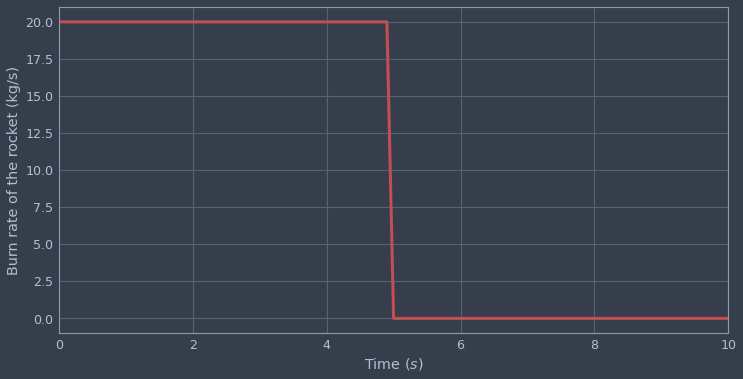

In [16]:
#Now, it's good to check if the burn rate it's correct. I made a plot with matplotlib
plt.figure(figsize=(12,6))
plt.plot(t,mr,lw=3,color='r')
plt.ylabel('Burn rate of the rocket (kg/s)')
plt.xlabel('Time $(s)$')
plt.xlim(t[0],10)

Now, it's time to get the $m_p$ for all the time. For that, only need to solve next integral:

\begin{equation}
m_p=m_{po}-\int_0^t\dot{m_p}dr
\end{equation}

It can be solved with the Simpson method. The method is the following:

\begin{equation}
\int_a^bf(x)dx\approx\frac{b-a}{6}\left[f(a)-f\left(\frac{a+b}{2}\right)+f(b)\right]
\end{equation}

## Remaining fuel

At time $t=$3.2 s, what is the mass (in kg) of rocket propellant remaining in the rocket?

In [17]:
#The function is mr.
def f(x):
    if (x<=5):
        return 20
    else:
        return 0

def integral(tf,t0):
    N=int(1e6)             #The total number of intervals.
    h=abs((tf-t0)/N)       #The increment of values.
    P1=(h/3)*(f(t0)+f(tf)) #The Part 1 of the equation.
    OS=0; ES=0            #Initialize the sums of values.
    #It's time to initialize the for loop
    for i in range(1,N-1):
        dx=t0+(i*h) #Here we decide the value to use
        if (i%2==0): #If i is an even, then use the Even sum 
            ES+=2*f(dx)
        else:
            OS+=4*f(dx) #If i is an odd, then use the Odd sum
    return P1+(h/3)*(OS+ES) #Return the final value of the integral

def mp(t):
    return mp0-integral(tf=t,t0=0) #The values to use in our Simpson method
print('The remaint mass of propellant is: ',round(mp(3.2),2))

The remaint mass of propellant is:  36.0


## Maximun velocity
What is the maximum speed of the rocket in $\frac{m}{s}$?

For solve the ODE, I make the next aproximation:

\begin{equation}
\frac{dx}{dt}=\frac{x_{i+1}-x_i}{\Delta t}
\end{equation}

So, the discretized ODE is as follows:

\begin{equation}
(m_s+m_p)\frac{v_{i+1}-v_i}{\Delta t}=\dot{m}_pv_e-(m_s+m_p)g-\frac{1}{2}\rho v|v|AC_D
\end{equation}

Leaving $v_{i+1}$ on the left and everything else on the right, is as follows:

\begin{equation}
v_{i+1}=v_i+\Delta t\left(\frac{\dot{m}_pv_e}{m_s+m_p}-\frac{\rho v|v|AC_D}{2(m_s+m_p)}-g\right)
\end{equation}

The past equation is the one that I'm gonna programming. Also I include the altitutde of the rocket:

\begin{equation}
h_{i+1}=h_i+\Delta tv
\end{equation}

In [18]:
def euler(mr,ve,m,dt,g,p,A,Cd):
    v=np.zeros(N)
    h=np.zeros(N)
    for i in range(0,N-1):
        F1=(mr[i]*ve)/(m+round(mp(t[i]),2))
        F2=(p*v[i]*abs(v[i])*A*Cd)/(2*(m+round(mp(t[i]),2)))
        v[i+1]=v[i]+dt*(F1-F2-g)
        h[i+1]=h[i]+(dt*v[i])
    return v,h

v,h=euler(mr,ve,m,dt,g,p,A,Cd)

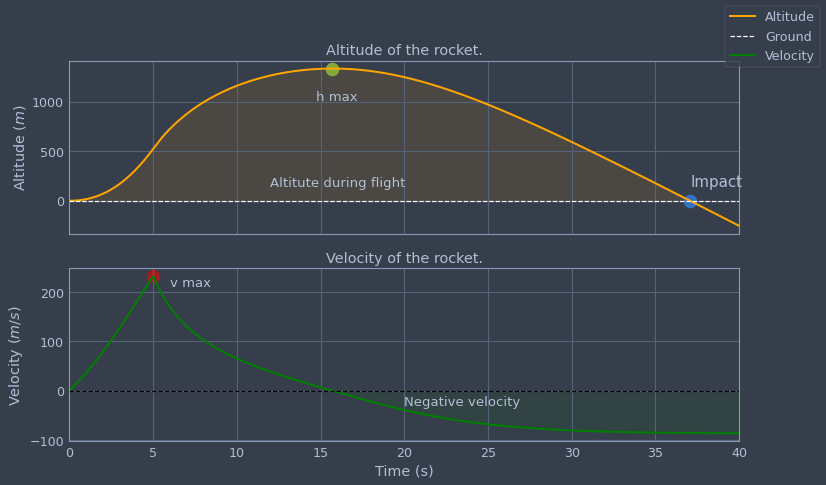

In [19]:
#It's time to make the plots
fig, axs= plt.subplots(2,figsize=(12,7),sharex=True)
#First graph, for the altitude h
axs[0].set_title('Altitude of the rocket.')
axs[0].plot(t,h,color='orange',lw=2,label='Altitude')
axs[0].plot(t,[0 for x in range(N)],'--',color='white',label='Ground')
axs[0].fill_between(t,h,where=(h>0),alpha=0.1,color='orange')
axs[0].scatter(t[(next(x for x in range(N) if (h[x]<0)))],0,lw=8)
axs[0].scatter(t[(next(x for x in range(N) if (h[x]==h.max())))],h.max(),lw=8)
axs[0].text(t[(next(x for x in range(N) if (h[x]==h.max())))]-1,h.max()-320,'h max')
axs[0].text(t[(next(x for x in range(N) if (h[x]<0)))],150, 'Impact', fontsize=15)
axs[0].text(t[0]+12,150,'Altitute during flight')
axs[0].set_ylabel('Altitude $(m)$')
#Second graph, for the velocity
axs[1].set_title('Velocity of the rocket.')
axs[1].plot(t,v,color='green',lw=2,label='Velocity')
axs[1].plot(t,[0 for x in range(N)],'--',color='black')
axs[1].fill_between(t,v,where=(v<0),alpha=0.1,color='green')
axs[1].scatter(t[(next(x for x in range(N) if (v[x]==v.max())))],v.max(),lw=8,alpha=0.5,color='red')
axs[1].text(t[(next(x for x in range(N) if (v[x]==v.max())))]+1,v.max()-20, 'v max')
axs[1].text(tf-20,-30,'Negative velocity')
axs[1].set_ylabel('Velocity $(m/s)$')
plt.xlim(t[0],t[N-1])
plt.xlabel('Time (s)')
fig.legend()

It's easy to see that the maximun velocity of the rocket occurs in $t=5$. To know that value, I use the .max() function of Python.

In [20]:
print('The maximum velocity is v=',round(v.max(),2),'m/s')

The maximum velocity is v= 232.11 m/s


At what time does this occur?

In [21]:
#I know that this occur when t=5, but let me check it.
print('The time for the maximun velocity is t=',round(t[(v.tolist()).index(v.max())],2),'s')

The time for the maximun velocity is t= 5.0 s


What is the altitude at this time?

In [22]:
#Like in the past question, I can do the same but this time for the h array.
print('The time for the maximun velocity is h=',round(h[(v.tolist()).index(v.max())],2),'m')

The time for the maximun velocity is h= 523.52 m


## Maximum height
What is the rocket's maximum altitude during flight?

In [23]:
#The maximun altitude can be showed with the .max() function.
print('The maximun altitude of the rocket is h=',round(h.max(),2),'m')

The maximun altitude of the rocket is h= 1334.18 m


At what time does this occur?

In [24]:
#I'm going to use the same code for the time at the maximun velocity
print('The time for the maximun velocity is t=',round(t[(h.tolist()).index(h.max())],2),'s')

The time for the maximun velocity is t= 15.7 s


## Impact
At what time does the rocket impact the ground?

In [25]:
#This time, I'm want to know when the altitude of the rocket is <0
print('The time when the rocket impact the ground is t=',t[(next(x for x in range(N) if (h[x]<0)))],'s')

The time when the rocket impact the ground is t= 37.1 s


What is the velocity of the rocket at time of impact?

In [26]:
print('the velocity at time of impact is v=',round(v[(next(x for x in range(N) if (h[x]<0)))],2),'m/s')

the velocity at time of impact is v= -86.01 m/s


# End of the code
Made by Ricardo Leal